### Sobel算子

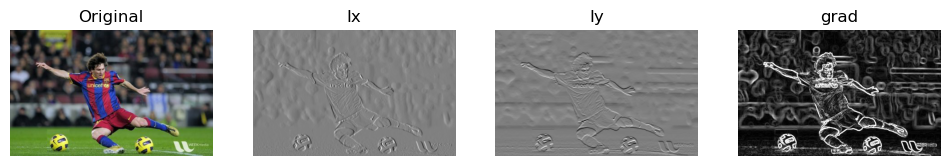

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("messi5.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)

Kx = np.array([[-1, 0, 1],
               [-2, 0, 2],
               [-1, 0, 1]], dtype=np.float32)
Ky = np.array([[1, 2, 1],
               [0, 0, 0],
               [-1, -2, -1]], dtype=np.float32)

def conv2d(img, kernel):
    h, w = img.shape
    kh, kw = kernel.shape
    pad = kh // 2
    padded = np.pad(img, pad, mode='reflect')
    out = np.zeros_like(img)
    for i in range(h):
        for j in range(w):
            region = padded[i:i+kh, j:j+kw]
            out[i, j] = np.sum(region * kernel)
    return out

Ix = conv2d(gray, Kx)
Iy = conv2d(gray, Ky)
grad = np.sqrt(Ix**2 + Iy**2)
grad = np.clip(grad, 0, 255).astype(np.uint8)

plt.figure(figsize=(12,6))
plt.subplot(1,4,1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title("Original"); plt.axis("off")
plt.subplot(1,4,2); plt.imshow(Ix, cmap='gray'); plt.title("Ix"); plt.axis("off")
plt.subplot(1,4,3); plt.imshow(Iy, cmap='gray'); plt.title("Iy"); plt.axis("off")
plt.subplot(1,4,4); plt.imshow(grad, cmap='gray'); plt.title("grad"); plt.axis("off")
plt.show()

### Canny Detection手动
先使用高斯滤波去除噪声，使图像更平滑。在前面的基础上非极大抑制并进行边缘连接。
非极大抑制就是根据梯度方向去比较对应附近的值，若小于则置为0，大于则保留，从而细化边缘并保留真实边缘点。

[[0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.02193823 0.09832033 0.16210282 0.09832033 0.02193823]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]]


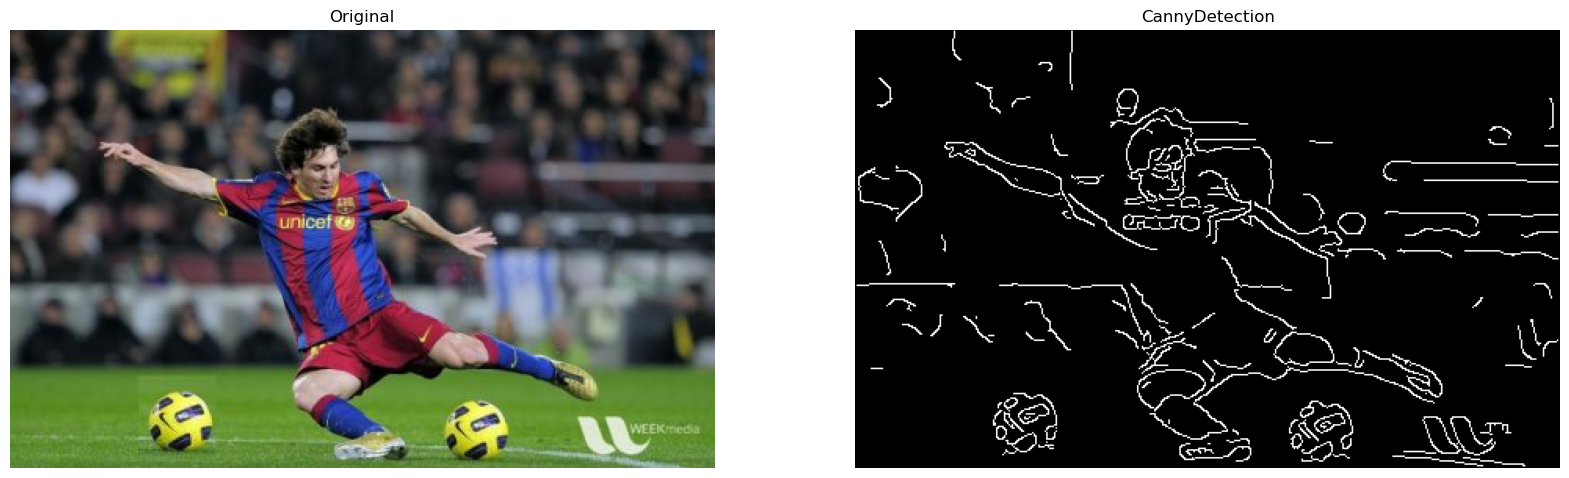

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("messi5.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)

def gaussian_kernel(size=5, sigma=1.0):
    k = size // 2
    x, y = np.mgrid[-k:k+1, -k:k+1]
    g = np.exp(-(x**2 + y**2) / (2*sigma**2))
    return g / g.sum()
print(gaussian_kernel(5,1.0))

blur = conv2d(gray, gaussian_kernel(5, 1.4))

Ix = conv2d(blur, Kx)
Iy = conv2d(blur, Ky)
G = np.sqrt(Ix**2 + Iy**2)
#print(G)
theta = np.arctan2(Iy, Ix)
#print(theta)

def suppr(G, theta):
    h, w = G.shape
    Z = np.zeros((h, w), dtype=np.float32)
    angle = theta * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1, h-1):
        for j in range(1, w-1):
            q = 255
            r = 255
            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                q = G[i, j+1]; r = G[i, j-1]
            elif (22.5 <= angle[i,j] < 67.5):
                q = G[i+1, j-1]; r = G[i-1, j+1]
            elif (67.5 <= angle[i,j] < 112.5):
                q = G[i+1, j]; r = G[i-1, j]
            elif (112.5 <= angle[i,j] < 157.5):
                q = G[i-1, j-1]; r = G[i+1, j+1]

            if (G[i,j] >= q) and (G[i,j] >= r):
                Z[i,j] = G[i,j]
    return Z

nms = suppr(G, theta)

low, high = 50, 100
strong = 255
weak = 50

res = np.zeros_like(nms)
strong_i, strong_j = np.where(nms >= high)
weak_i, weak_j = np.where((nms >= low) & (nms < high))
res[strong_i, strong_j] = strong
res[weak_i, weak_j] = weak

# 滞后连接：弱但连通的边缘被保留，孤立的弱响应被抑制；
def hysteresis(img):
    h, w = img.shape
    for i in range(1, h-1):
        for j in range(1, w-1):
            if img[i,j] == weak:
                if np.any(img[i-1:i+2, j-1:j+2] == strong):
                    img[i,j] = strong
                else:
                    img[i,j] = 0
    return img

edges = hysteresis(res)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title("Original"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(edges, cmap='gray'); plt.title("CannyDetection"); plt.axis("off")
plt.show()


### Harris Detection手动实现



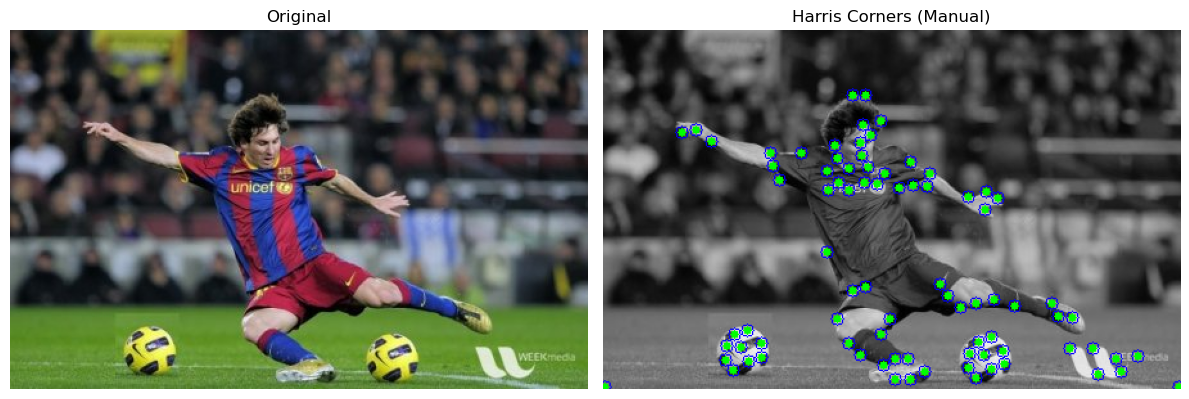

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
img = cv2.imread("messi5.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)


Ixx = Ix ** 2
Iyy = Iy ** 2
Ixy = Ix * Iy

G = gaussian_kernel(7, 1.5)
Sxx = conv2d(Ixx, G)
Syy = conv2d(Iyy, G)
Sxy = conv2d(Ixy, G)

k = 0.04
det = Sxx * Syy - Sxy**2
trace = Sxx + Syy
R = det - k * (trace**2)

R_norm = (R - np.min(R)) / (np.max(R) - np.min(R))
corner_threshold = 0.10
corners = R_norm > corner_threshold

coords = np.argwhere(corners)
responses = R_norm[corners]
sorted_idx = np.argsort(-responses)
coords = coords[sorted_idx]

min_dist = 10
final_corners = []
for y, x in coords:
    if not final_corners:
        final_corners.append((x, y))
    else:
        keep = True
        for px, py in final_corners:
            if (x - px)**2 + (y - py)**2 < min_dist**2:
                keep = False
                break
        if keep:
            final_corners.append((x, y))

corner_img = cv2.cvtColor(gray.astype(np.uint8), cv2.COLOR_GRAY2RGB)
for x, y in final_corners:
    cv2.circle(corner_img, (x, y), radius=3, color=(0, 255, 0), thickness=-1)
    cv2.circle(corner_img, (x, y), radius=5, color=(0, 0, 255), thickness=1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(corner_img)
plt.title("Harris Corners (Manual)")
plt.axis("off")

plt.tight_layout()
plt.show()

### 直方图均衡化
展平后画直方图，归一化cdf，把原图灰度映射到新的灰度值，使得灰度分布更均匀。

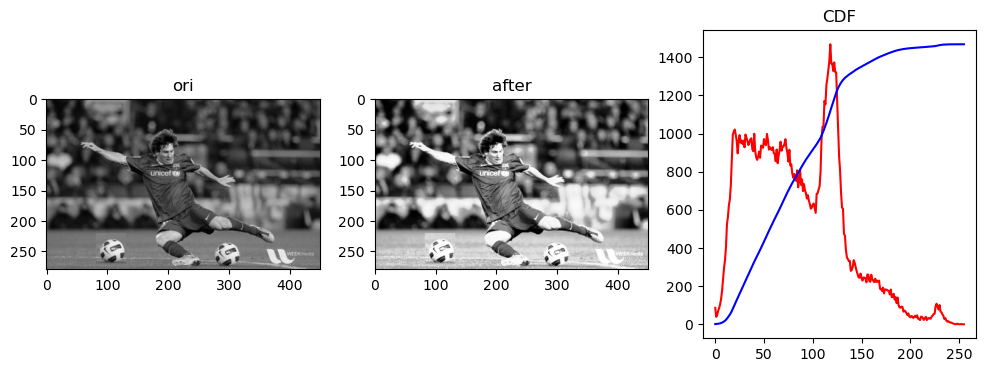

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("messi5.jpg", cv2.IMREAD_GRAYSCALE)

hist, bins = np.histogram(img.flatten(), 256, [0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()

cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')
equalized = cdf[img]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1), plt.imshow(img, cmap='gray'), plt.title("ori")
plt.subplot(1,3,2), plt.imshow(equalized, cmap='gray'), plt.title("after")
plt.subplot(1,3,3), plt.plot(hist, color='r'), plt.plot(cdf_normalized, color='b'), plt.title("CDF")
plt.show()